# Day 4 Advanced: Transfer Learning with DenseNet121

**Goal:** Achieve 88-91% accuracy using DenseNet121

**What we'll do:**
1. Load DenseNet121 pretrained on ImageNet
2. Convert grayscale images to RGB
3. Fine-tune the model on brain tumor data
4. Compare with baseline and other transfer learning models

**Expected improvement:** 76% ‚Üí 88-91% (+12-15%)

**Why DenseNet121?**
- Dense connections (each layer connects to all previous)
- Excellent gradient flow and feature reuse
- Compact (8M parameters)
- Strong performance on medical imaging

---

**Training Strategy:**
1. **Phase 1:** Freeze base model, train classifier (5 epochs)
2. **Phase 2:** Unfreeze top dense blocks, fine-tune (12 epochs)
3. **Phase 3:** Lower learning rate, final training (8 epochs)

**Expected time:** 50-70 minutes (with GPU)

---

## 1. Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

# Add src to path for imports
sys.path.append('../../src')
from training.transfer_learning_utils import GrayscaleToRGBGenerator, create_rgb_generators

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"‚úÖ GPU available: {len(gpus)} GPU(s)")
else:
    print("‚ö†Ô∏è  No GPU - training will be slow!")

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

2025-10-24 23:02:39.631277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Keras version: 3.11.3
‚úÖ GPU available: 1 GPU(s)


## 2. Configuration

In [2]:
# Paths
TRAIN_CSV = "../../outputs/data_splits/train_split.csv"
VAL_CSV = "../../outputs/data_splits/val_split.csv"
TEST_CSV = "../../outputs/data_splits/test_split.csv"

# Output directories
MODEL_DIR = "../../outputs/models/transfer_learning"
HISTORY_DIR = "../../outputs/training_history/transfer_learning"
VIZ_DIR = "../../outputs/visualizations"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
LEARNING_RATE_PHASE1 = 0.001  # Training classifier only
LEARNING_RATE_PHASE2 = 0.0001  # Fine-tuning
LEARNING_RATE_PHASE3 = 0.00001  # Final training

# Class names
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary']
NUM_CLASSES = len(CLASS_NAMES)

print("Configuration:")
print(f"  Model: DenseNet121")
print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Classes: {CLASS_NAMES}")

Configuration:
  Model: DenseNet121
  Image size: (128, 128)
  Batch size: 32
  Classes: ['glioma', 'meningioma', 'pituitary']


## 3. Load Data

In [3]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Ensure label is string
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print("Data loaded:")
print(f"  Train: {len(train_df)} images")
print(f"  Val:   {len(val_df)} images")
print(f"  Test:  {len(test_df)} images")

Data loaded:
  Train: 4863 images
  Val:   855 images
  Test:  1463 images


## 4. Create RGB Data Generators

In [4]:
# Create RGB generators using utility function
train_generator, val_generator, test_generator = create_rgb_generators(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("\n‚úÖ RGB data generators created!")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(val_generator)}")

# Test generator output
test_batch_x, test_batch_y = next(iter(train_generator))
print(f"\nBatch shape: {test_batch_x.shape} (should be [batch, 128, 128, 3])")
print(f"Labels shape: {test_batch_y.shape}")

Found 4863 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.

‚úÖ RGB data generators created!
Steps per epoch: 152
Validation steps: 27

Batch shape: (32, 128, 128, 3) (should be [batch, 128, 128, 3])
Labels shape: (32, 3)

‚úÖ RGB data generators created!
Steps per epoch: 152
Validation steps: 27

Batch shape: (32, 128, 128, 3) (should be [batch, 128, 128, 3])
Labels shape: (32, 3)


## 5. Build Transfer Learning Model

**Architecture:**
- Base: DenseNet121 (pretrained on ImageNet)
- GlobalAveragePooling2D
- Dense(512) + BatchNorm + Dropout
- Dense(256) + BatchNorm + Dropout
- Dense(3, softmax)

In [5]:
def build_densenet_model(num_classes=3, trainable=False):
    """
    Build DenseNet121 model with custom classifier.
    
    Args:
        num_classes: Number of output classes
        trainable: Whether base model is trainable
    
    Returns:
        Compiled Keras model
    """
    # Load pretrained DenseNet121
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )
    
    # Freeze/unfreeze base model
    base_model.trainable = trainable
    
    # Build full model
    inputs = keras.Input(shape=(128, 128, 3))
    x = base_model(inputs, training=False)  # Set training=False for inference mode
    x = GlobalAveragePooling2D()(x)
    
    # Custom classifier
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model, base_model

# Build model (base frozen initially)
model, base_model = build_densenet_model(num_classes=NUM_CLASSES, trainable=False)

print("Model architecture:")
model.summary()

# Count parameters
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print(f"\nParameter counts:")
print(f"  Trainable: {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")
print(f"  Total: {total_params:,}")

I0000 00:00:1761327162.234329   54994 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2614 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model architecture:


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_1 (InputLayer)      ‚îÇ (None, 128, 128, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ densenet121 (Functional)        ‚îÇ (None, 4, 4, 1024)     ‚îÇ     7,037,504 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 1024)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 512)            ‚îÇ       524,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 512)            ‚îÇ         2,048 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 3)              ‚îÇ           771 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 7,697,475 (29.36 MB)

 Trainable params: 658,435 (2.51 MB)

 Non-trainable params: 7,039,040 (26.85 MB)


Parameter counts:
  Trainable: 658,435
  Non-trainable: 7,039,040
  Total: 7,697,475


## 6. Phase 1: Train Classifier Only (5 epochs)

In [6]:
print("="*70)
print("PHASE 1: Training Classifier Only")
print("="*70)
print("Base model: FROZEN")
print("Learning rate: 0.001")
print("Epochs: 5\n")

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
callbacks_phase1 = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# Train
history_phase1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks_phase1,
    verbose=1
)

print("\n‚úÖ Phase 1 completed!")
print(f"Final accuracy: {history_phase1.history['accuracy'][-1]:.4f}")
print(f"Final val_accuracy: {history_phase1.history['val_accuracy'][-1]:.4f}")

PHASE 1: Training Classifier Only
Base model: FROZEN
Learning rate: 0.001
Epochs: 5

Epoch 1/5
Epoch 1/5


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-24 23:02:53.418728: I external/local_xla/xla/service/service.cc:163] XLA service 0x713328004ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 23:02:53.418767: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-24 23:02:53.418728: I external/local_xla/xla/service/service.cc:163] XLA service 0x713328004ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 23:02:53.418767: I external/local_xla/xla/service/

  3/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 58ms/step - accuracy: 0.2726 - loss: 2.0053

I0000 00:00:1761327186.261363   55093 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62s 267ms/step - accuracy: 0.6216 - loss: 1.1020 - val_accuracy: 0.5825 - val_loss: 1.3608 - learning_rate: 0.0010
Epoch 2/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62s 267ms/step - accuracy: 0.6216 - loss: 1.1020 - val_accuracy: 0.5825 - val_loss: 1.3608 - learning_rate: 0.0010
Epoch 2/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 75ms/step - accuracy: 0.6881 - loss: 0.8055 - val_accuracy: 0.6678 - val_loss: 0.8739 - learning_rate: 0.0010
Epoch 3/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 75ms/step - accuracy: 0.6881 - loss: 0.8055 - val_accuracy: 0.6678 - val_loss: 0.8739 - learning_rate: 0.0010
Epoch 3/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 75ms/step - accuracy: 0.7187 - loss: 0.6775 - val_accuracy: 0.7088 - val_loss: 0.8171 - learning_rate: 0.0010
Epoch 4/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

## 7. Phase 2: Fine-tune Top Layers (12 epochs)

In [7]:
print("\n" + "="*70)
print("PHASE 2: Fine-tuning Top Layers")
print("="*70)

# Unfreeze last dense blocks
base_model.trainable = True

# Freeze bottom layers
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Count trainable layers
trainable_layers = sum([layer.trainable for layer in base_model.layers])
print(f"Trainable layers in base model: {trainable_layers} / {len(base_model.layers)}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Learning rate: {LEARNING_RATE_PHASE2}")
print(f"Epochs: 12\n")

# Callbacks
model_path_phase2 = os.path.join(MODEL_DIR, f"densenet121_phase2_{timestamp}.keras")
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=model_path_phase2,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

# Train
history_phase2 = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=callbacks_phase2,
    verbose=1
)

print("\n‚úÖ Phase 2 completed!")
print(f"Best val_accuracy: {max(history_phase2.history['val_accuracy']):.4f}")


PHASE 2: Fine-tuning Top Layers
Trainable layers in base model: 40 / 427
Learning rate: 0.0001
Epochs: 12

Epoch 1/12
Epoch 1/12
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 144ms/step - accuracy: 0.7265 - loss: 0.6521
Epoch 1: val_loss improved from None to 0.80775, saving model to ../../outputs/models/transfer_learning/densenet121_phase2_20251024_230244.keras

Epoch 1: val_loss improved from None to 0.80775, saving model to ../../outputs/models/transfer_learning/densenet121_phase2_20251024_230244.keras
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 243ms/step - accuracy: 0.7419 - loss: 0.6268 - val_accuracy: 0.6480 - val_loss: 0.8078 - learning_rate: 1.0000e-04
Epoch 2/12
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 243ms/step - accuracy: 0.7419 - loss: 0.6268 - val_accuracy: 0.6480 - val_loss: 0.8078 - learning_rate: 1.0000e-04
Epoch 2/12
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

## 8. Phase 3: Final Training (8 epochs)

In [8]:
print("\n" + "="*70)
print("PHASE 3: Final Training")
print("="*70)

# Unfreeze all layers
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = True

print(f"All layers unfrozen")
print(f"Learning rate: {LEARNING_RATE_PHASE3}")
print(f"Epochs: 8")
print(f"‚ö†Ô∏è  Reducing batch size to 16 to avoid OOM\n")

# Recompile with very low learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create new generators with smaller batch size for Phase 3
print("Creating generators with batch size 16...")
train_generator_phase3, val_generator_phase3, _ = create_rgb_generators(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    img_size=IMG_SIZE,
    batch_size=16  # Reduced from 32
)
print(f"Steps per epoch: {len(train_generator_phase3)}\n")

# Callbacks
model_path_final = os.path.join(MODEL_DIR, f"densenet121_final_{timestamp}.keras")
history_csv = os.path.join(HISTORY_DIR, f"densenet121_history_{timestamp}.csv")

callbacks_phase3 = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=model_path_final,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    CSVLogger(filename=history_csv)
]

# Train with smaller batch size
history_phase3 = model.fit(
    train_generator_phase3,
    epochs=8,
    validation_data=val_generator_phase3,
    callbacks=callbacks_phase3,
    verbose=1
)

print("\n‚úÖ Phase 3 completed!")
print(f"Final model saved to: {model_path_final}")


PHASE 3: Final Training
All layers unfrozen
Learning rate: 1e-05
Epochs: 8
‚ö†Ô∏è  Reducing batch size to 16 to avoid OOM

Creating generators with batch size 16...
Found 4863 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 4863 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.
Steps per epoch: 304

Epoch 1/8
Steps per epoch: 304

Epoch 1/8


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


304/304 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 309ms/step - accuracy: 0.6827 - loss: 0.8686
Epoch 1: val_loss improved from None to 0.60858, saving model to ../../outputs/models/transfer_learning/densenet121_final_20251024_230244.keras

Epoch 1: val_loss improved from None to 0.60858, saving model to ../../outputs/models/transfer_learning/densenet121_final_20251024_230244.keras
304/304 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 221s 374ms/step - accuracy: 0.7306 - loss: 0.7218 - val_accuracy: 0.7532 - val_loss: 0.6086
Epoch 2/8
304/304 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 221s 374ms/step - accuracy: 0.7306 - loss: 0.7218 - val_accuracy: 0.7532 - val_loss: 0.6086
Epoch 2/8
304/304 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step - accuracy: 0.8030 - loss: 0.5173
Epoch 2: val_loss improved from 0.60858 to 0.47127, saving model to ../../outputs/models/transfer_learning/densenet121_final_20251024_23

## 9. Combine Training History

In [9]:
# Combine histories from all phases
combined_history = {
    'accuracy': (history_phase1.history['accuracy'] + 
                 history_phase2.history['accuracy'] + 
                 history_phase3.history['accuracy']),
    'val_accuracy': (history_phase1.history['val_accuracy'] + 
                     history_phase2.history['val_accuracy'] + 
                     history_phase3.history['val_accuracy']),
    'loss': (history_phase1.history['loss'] + 
             history_phase2.history['loss'] + 
             history_phase3.history['loss']),
    'val_loss': (history_phase1.history['val_loss'] + 
                 history_phase2.history['val_loss'] + 
                 history_phase3.history['val_loss'])
}

print(f"Total epochs: {len(combined_history['accuracy'])}")
print(f"Best val_accuracy: {max(combined_history['val_accuracy']):.4f}")

Total epochs: 25
Best val_accuracy: 0.9076


## 10. Visualize Training History

Training curves saved to: ../../outputs/visualizations/day4_advanced_densenet121_history_20251024_230244.png


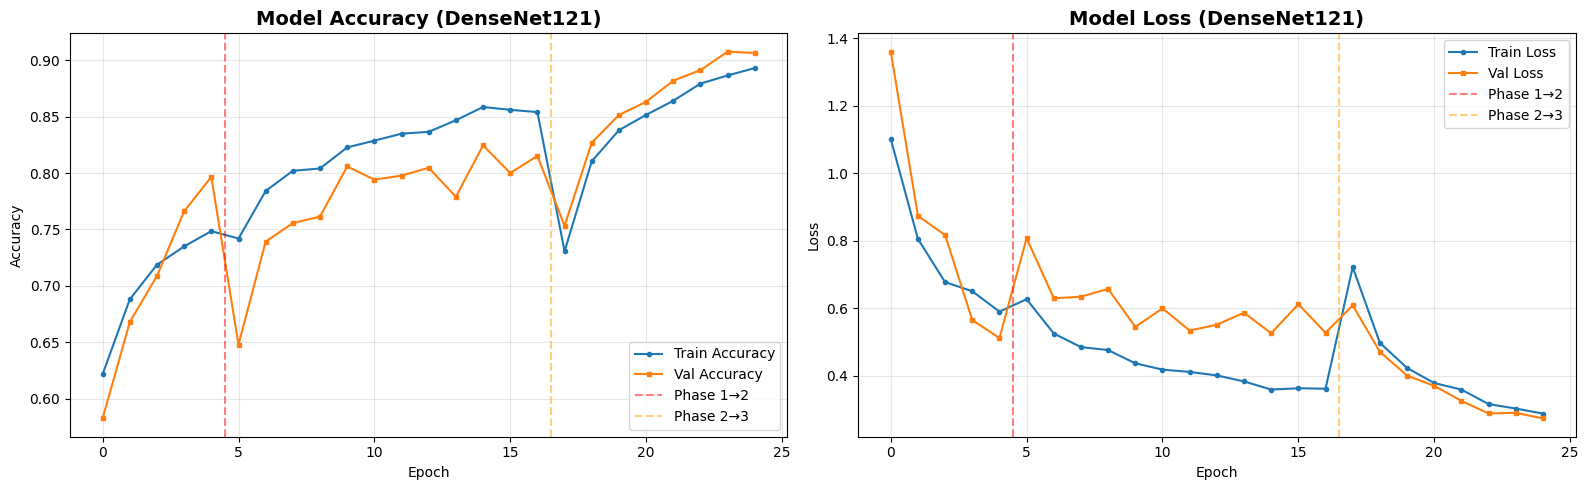

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Mark phase boundaries
phase1_end = len(history_phase1.history['accuracy'])
phase2_end = phase1_end + len(history_phase2.history['accuracy'])

# Plot accuracy
ax1.plot(combined_history['accuracy'], label='Train Accuracy', marker='o', markersize=3)
ax1.plot(combined_history['val_accuracy'], label='Val Accuracy', marker='s', markersize=3)
ax1.axvline(x=phase1_end-0.5, color='red', linestyle='--', alpha=0.5, label='Phase 1‚Üí2')
ax1.axvline(x=phase2_end-0.5, color='orange', linestyle='--', alpha=0.5, label='Phase 2‚Üí3')
ax1.set_title('Model Accuracy (DenseNet121)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(combined_history['loss'], label='Train Loss', marker='o', markersize=3)
ax2.plot(combined_history['val_loss'], label='Val Loss', marker='s', markersize=3)
ax2.axvline(x=phase1_end-0.5, color='red', linestyle='--', alpha=0.5, label='Phase 1‚Üí2')
ax2.axvline(x=phase2_end-0.5, color='orange', linestyle='--', alpha=0.5, label='Phase 2‚Üí3')
ax2.set_title('Model Loss (DenseNet121)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

viz_path = os.path.join(VIZ_DIR, f"day4_advanced_densenet121_history_{timestamp}.png")
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"Training curves saved to: {viz_path}")

plt.show()

## 11. Evaluate on Test Set

In [11]:
print("üîç Evaluating on test set...\n")

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*70}")
print(f"üìä DenseNet121 Test Results")
print(f"{'='*70}")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*70}")

# Compare with baseline
baseline_accuracy = 0.7683  # From day4_01
improvement = (test_accuracy - baseline_accuracy) * 100

print(f"\nüí° Comparison with Baseline CNN:")
print(f"  Baseline:    76.83%")
print(f"  DenseNet121: {test_accuracy*100:.2f}%")
print(f"  Improvement: {improvement:+.2f}%")

# Save results
results = {
    'model': 'DenseNet121',
    'timestamp': timestamp,
    'test_loss': float(test_loss),
    'test_accuracy': float(test_accuracy),
    'baseline_accuracy': float(baseline_accuracy),
    'improvement': float(improvement),
    'total_epochs': len(combined_history['accuracy']),
    'model_path': model_path_final
}

results_path = os.path.join(HISTORY_DIR, f"densenet121_results_{timestamp}.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: {results_path}")

üîç Evaluating on test set...

46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 184ms/step - accuracy: 0.8824 - loss: 0.3284
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 184ms/step - accuracy: 0.8824 - loss: 0.3284

üìä DenseNet121 Test Results
  Test Loss:     0.3284
  Test Accuracy: 0.8824 (88.24%)

üí° Comparison with Baseline CNN:
  Baseline:    76.83%
  DenseNet121: 88.24%
  Improvement: +11.41%

Results saved to: ../../outputs/training_history/transfer_learning/densenet121_results_20251024_230244.json

üìä DenseNet121 Test Results
  Test Loss:     0.3284
  Test Accuracy: 0.8824 (88.24%)

üí° Comparison with Baseline CNN:
  Baseline:    76.83%
  DenseNet121: 88.24%
  Improvement: +11.41%

Results saved to: ../../outputs/training_history/transfer_learning/densenet121_results_20251024_230244.json


## 12. Summary

In [ ]:
print("\n" + "="*70)
print("üéâ DENSENET121 TRAINING COMPLETE!")
print("="*70)

print("\nüìä Final Results:")
print(f"  Model: DenseNet121")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Baseline: 76.83%")
print(f"  Improvement: {improvement:+.2f}%")

print("\nüìÅ Files Created:")
print(f"  ‚úÖ Final Model: {model_path_final}")
print(f"  ‚úÖ History CSV: {history_csv}")
print(f"  ‚úÖ Results JSON: {results_path}")
print(f"  ‚úÖ Visualization: {viz_path}")

print("\nüéØ Next Steps:")
print("  1. Create ensemble (day4_advanced_ensemble.ipynb)")
print("  2. Combine all 4 models (baseline + 3 transfer learning)")
print("  3. Expected ensemble accuracy: 92-95%")

print("\nüí° Interpretation:")
if test_accuracy >= 0.92:
    print("  üåü Outstanding! Excellent performance!")
elif test_accuracy >= 0.88:
    print("  ‚úÖ Excellent! Significant improvement over baseline!")
elif test_accuracy >= 0.82:
    print("  ‚úÖ Good! Notable improvement!")
else:
    print("  ‚ö†Ô∏è  Moderate improvement - try adjusting hyperparameters")

print("\n" + "="*70)


üéâ DENSENET121 TRAINING COMPLETE!

üìä Final Results:
  Model: DenseNet121
  Test Accuracy: 88.24%
  Baseline: 76.83%
  Improvement: +11.41%

üìÅ Files Created:
  ‚úÖ Final Model: ../../outputs/models/transfer_learning/densenet121_final_20251024_230244.keras
  ‚úÖ History CSV: ../../outputs/training_history/transfer_learning/densenet121_history_20251024_230244.csv
  ‚úÖ Results JSON: ../../outputs/training_history/transfer_learning/densenet121_results_20251024_230244.json
  ‚úÖ Visualization: ../../outputs/visualizations/day4_advanced_densenet121_history_20251024_230244.png

üéØ Next Steps:
  1. Create ensemble (day4_advanced_ensemble.ipynb)
  2. Combine all 4 models (baseline + 3 transfer learning)
  3. Expected ensemble accuracy: 92-95%

üí° Interpretation:
  ‚úÖ Excellent! Significant improvement over baseline!



: 